# Arrays in numpy: indexing, ufuncs, broadcasting

Last week you learned why numpy was created. This week we are going to dig a little deeper in this fundamental piece of the scientific python ecosystem.

This chapter contains a lot of new concepts and tools, and I'm aware that you won't be able to remember all of them at once. My objective here is to help you to better understand the numpy documentation when you'll need it, by being prepared for new semantics like "advanced indexing" or "ufunc" (universal function).  There are many books about numpy (I've listed some in the [External resources](../references.ipynb) section), and my personal recommendation is to learn it on the go (i.e. step by step, task after task). I still hope that this chapter (even if too short for such an important library) will help a little bit.

## Anatomy of a ndarray

*From the [numpy reference](https://docs.scipy.org/doc/numpy/reference/arrays.html):*

N-dimensional [ndarray](https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html#arrays-ndarray)'s are the core structure of the numpy library. It is a multidimensional container of items of the same type and size. The number of dimensions and items in an array is defined by its shape, which is a tuple of N positive integers that specify the number of items in each dimension. The type of items in the array is specified by a separate data-type object (dtype), one of which is associated with each ndarray.

All ndarrays are homogenous: every item takes up the same size block of memory, and all blocks are interpreted in exactly the same way. 

An item extracted from an array, e.g., by indexing, is represented by a Python object whose type is one of the array scalar types built in NumPy.

![img](https://docs.scipy.org/doc/numpy/_images/threefundamental.png)

**Figure:** Conceptual diagram showing the relationship between the three fundamental objects used to describe the data in an array: 1) the ndarray itself, 2) the data-type object that describes the layout of a single fixed-size element of the array, 3) the array-scalar Python object that is returned when a single element of the array is accessed.

In [1]:
import numpy as np
x = np.array([[1, 2, 3], [4, 5, 6]], np.int32)
type(x)

numpy.ndarray

In [2]:
x.dtype  # x is of type ndarray, but the data it contains is not

dtype('int32')

Numpy was created to work with numbers, and large arrays of numbers with the same type. Some of ``ndarray``'s attributes give us information about the memory they need:

In [3]:
print(x.itemsize)  # size of one element (np.int32) in bytes 
print(x.nbytes)  # size of 2 * 3 = 6 elements in bytes 

4
24


The "shape" of an array formalizes how the data values are accessed or printed: 

In [4]:
x.shape

(2, 3)

In [5]:
print(x)

[[1 2 3]
 [4 5 6]]


However, the data is one-dimensional and contiguous *in memory*. I.e. the 1D segment of computer memory stored by the array is combined with an indexing scheme that maps N-dimensional indexes into the location of an item in the block. Concretely, this means that there is no difference in the memory layout of these two arrays:

In [6]:
a = np.arange(9)
b = a.reshape((3, 3))  # what does "reshape" do?

Both are internally stored using a one dimensional memory block. The difference lies in the way numpy gives access to the internal data:

In [7]:
a[4], b[1, 1]

(4, 4)

This means that elementwise operations have the same execution speed for N dimensional arrays as for 1-D arrays. Now, let's replace an element from array b:

In [8]:
b[1, 1] = 99
b

array([[ 0,  1,  2],
       [ 3, 99,  5],
       [ 6,  7,  8]])

Since the indexing ``[1, 1]`` is on the left-hand side of the assignment operator, we modified b **in-place**. Numpy located the block of memory that needed to be changed and replaced it with another number. Since all these numbers are integers with a fixed memory size, this is not a problem. But what happens if we try to assign another data type?

In [9]:
b[1, 1] = 999.99
b

array([[  0,   1,   2],
       [  3, 999,   5],
       [  6,   7,   8]])

The float is converted to an integer! This is a dangerous "feature" of numpy and should be used with care. 

Another extremely important mechanism of ndarrays is their internal handling of data. Indeed:

In [10]:
a

array([  0,   1,   2,   3, 999,   5,   6,   7,   8])

What happened here? *Modifying the data in b also modified the data in a*! More precisely, both arrays share the same internal data: b is a **view** of the data owned by a.

In [11]:
b.base is a

True

In [12]:
a.base is None

True

In [13]:
np.shares_memory(a, b)

True

This allows for memory efficient reshaping and vector operations on numpy arrays, but is a source of confusion for many. in this lecture, we will look into more detail which operations return a view and which return a copy. 

```{warning}
The concept of **views** and **copies** of `ndarray` is central to numpy. Make sure you understood the examples above well before going on.
```

## Creating ndarrays

There are [many ways](https://docs.scipy.org/doc/numpy/reference/routines.array-creation.html#array-creation-routines) to create numpy arrays. The functions you will use most often are: 

### ``np.emtpy``, ``np.zeros``, ``np.ones``, ``np.full``

These three work the same way, The first argument defines the shape of the array:

In [14]:
a = np.ones((2, 3, 4))
a

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

The ``dtype`` kwarg specifies the type:

In [15]:
np.zeros(2, dtype=bool)

array([False, False])

In [16]:
a = np.empty((2, 3), dtype=np.float32)
a.dtype

dtype('float32')

What is an "empty" array by the way?

In [17]:
a

array([[2.3694278e-38, 2.3694278e-38, 2.3694278e-38],
       [2.3694278e-38, 2.3694278e-38, 2.3694278e-38]], dtype=float32)

What are all these numbers? As it turns out, they are completely unpredictable: with ``np.empty``, numpy just takes a free slot of memory somewhere, and doesn't change the bits in it. Computers are smart enough: when deleting a variable, they are just removing the pointer (the address) to this series of bits, not deleting them (this would cost too much time). 

```{tip} By the way
The same is true for the "delete" function in your operating system by the way: even after "deleting" a file, be aware that a motivated hacker can find and recover your data ([data-recovery](https://en.wikipedia.org/wiki/Data_recovery)).
```

So, why using ``np.empty`` instead of ``np.zeros``? Mostly for performance reasons. With ``np.empty``, numpy spares the step of setting all the underlying bits to zero:

In [18]:
%timeit np.empty(20000)

668 ns ± 10.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [19]:
%timeit np.ones(20000)

6.65 µs ± 78.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


So at least a factor 10 faster on my laptop. If you know that your are going to use your array as data storage and fill it later on, it *might* be a good idea to use ``np.empty``. In practice, however, performance doesn't matter that much and avoiding bugs is more important: initialize your arrays with NaNs (Not a Number) in order to easily find out if all values were actually set by your program after completion:

In [20]:
np.full((2, 3), np.NaN)

array([[nan, nan, nan],
       [nan, nan, nan]])

### ``np.array``

``np.array`` converts existing data to a ndarray:

In [21]:
np.array([[1, 2, 3], [4, 5, 6]], np.float64)

array([[1., 2., 3.],
       [4., 5., 6.]])

But be aware that it doesn't behave like the python equivalent ``list``!

In [22]:
list('abcd'), np.array('abcd')

(['a', 'b', 'c', 'd'], array('abcd', dtype='<U4'))

### ``np.copy``

When a variable is assigned to another variable in python, it creates **a new reference to the object it contains, NOT a copy**:

In [23]:
a = np.zeros(3)
b = a
b[1] = 1
a  # ups, didn't want to do that!

array([0., 1., 0.])

This behavior is not specific to numpy, but to python itself. Remember? Can you predict the outcome of the following code:

```python
a = [1, 2, 3]
b = a
b.append(4)
print(a)
```
If you learned programming with another language (Matlab, R, C), compare this behavior to the language you used before. 

This is why ``np.copy`` is useful:

In [24]:
a = np.zeros(3)
b = a.copy()  # same as np.copy(a)
b[1] = 1
a  # ah!

array([0., 0., 0.])

### ``np.arange``

In [25]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Be careful! the start and stop arguments define the half open interval ``[start, stop[``:

In [26]:
np.arange(3, 15, 3) 

array([ 3,  6,  9, 12])

In [27]:
np.arange(3, 15.00000001, 3) 

array([ 3.,  6.,  9., 12., 15.])

### ``np.linspace``

Regularly spaced intervals between two values (both limits are included this time):

In [28]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

## The shape of ndarrays 

Is numpy [row-major or column-major order](https://en.wikipedia.org/wiki/Row-_and_column-major_order)? 

The default order in numpy is that of the C-language: **row-major**. This means that the array:

In [29]:
a = np.array([[1, 2, 3], 
              [4, 5, 6]])
a

array([[1, 2, 3],
       [4, 5, 6]])

has two rows and three columns, the rows being listed first:

In [30]:
a.shape

(2, 3)

and that the internal representation in memory is sorted by rows:

In [31]:
a.flatten()

array([1, 2, 3, 4, 5, 6])

A consequence is that reading data out of rows (first dimension in the array) is usually a bit faster than reading out of columns:

In [32]:
t = np.zeros((1000, 1000))
%timeit t[[0], :]
%timeit t[:, [0]]

2.3 µs ± 70.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.94 µs ± 139 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


This is different from some other languages like FORTRAN, Matlab, R, or IDL. In my opinion though, most of the time it doesn't matter much to remember whether it is row- or column-major, as long as you remember which dimension is what. Still, this can be a source of confusion at first, especially if you come from one of these column-major languages.

Most datasets are then going to store the data in a way that allows faster retrieval along the dimension which is read most often: for geophysical datasets, this is often going to be the "time" dimension, i.e. the size of the time dimension is going to give the size of `array.shape[0]`. 

My personal way to deal with this when I started using numpy is that I always thought of numpy being in the "wrong" order. If you have data defined in four dimensions (x, y, z, t in the "intuitive", mathematical order), then it is often stored in numpy with the shape (t, z, y, x). 

Remember the 4D arrays that we use a lot in the climate lecture: they were stored on disk as netCDF files, and their description read:

```
	double t(month, level, latitude, longitude) ;
		t:least_significant_digit = 2LL ;
		t:units = "K" ;
		t:long_name = "Temperature" ;
```

which is also the order used by numpy:

In [1]:
# you can't do this at home!
import netCDF4
with netCDF4.Dataset('ERA-Int-MonthlyAvg-4D-T.nc') as nc:
    temp = nc.variables['t'][:]
temp.shape

(12, 15, 241, 480)

This order might be different in other languages. It's just a convention!

Looping over time and z (which happens more often than looping over x or y) is as easy as:

In [34]:
for time_slice in temp:
    for z_slice in time_slice:
        # Do something useful with your 2d spatial slice
        assert z_slice.shape == (241, 480)

There is one notable exception to this rule though. RGB images:

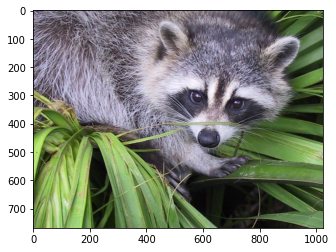

In [35]:
from scipy import misc
import matplotlib.pyplot as plt
img = misc.face()
plt.imshow(img);

In [36]:
img.shape

(768, 1024, 3)

``img`` is in RGB space, and (in my humble opinion) the third dimension (the channel) *should* be at the first place in order to be consistent with the z, y, x order of the temperature variable above. Because of this strange order, if you want to unpack (or loop over) each color channel you'll have to do the counter intuitive:

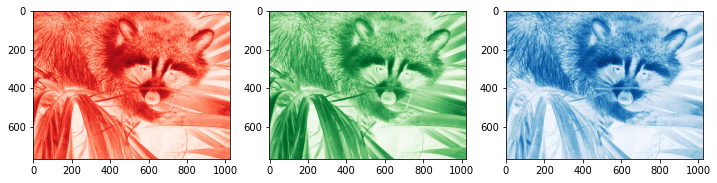

In [37]:
numpy_ordered_img = np.rollaxis(img, 2)
R, G, B = numpy_ordered_img
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(R, cmap='Reds'); ax2.imshow(G, cmap='Greens'); ax3.imshow(B, cmap='Blues');

I guess there must be historical reasons for this choice

Anyways, with some experience you'll see that there is *always* a way to get numpy arrays in the shape you want them. It is sometimes going to be confusing and you are going to need some googling skills (like the ``np.rollaxis`` trick from above), but you'll manage. All the tools at your disposition for these purposes are listed in the [array manipulation](https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.array-manipulation.html) documentation page.

*Parenthesis: note that numpy also allows to use the column-major order you may be familiar with:*

In [38]:
a = np.array([[1, 2, 3], 
              [4, 5, 6]])
a.flatten(order='F')

array([1, 4, 2, 5, 3, 6])

*I **do not recommend** to take this path unless really necessary: sooner or later you are going to regret it. If you really need to flatten an array this way, I recommend the more numpy-like:*

In [39]:
a.T.flatten()

array([1, 4, 2, 5, 3, 6])

## Indexing 

**Indexing** refers to the act of accessing values in an array by their **index**, i.e. their position in the array.

There are many ways to index arrays, and the [numpy documentation](https://docs.scipy.org/doc/numpy-1.14.0/reference/arrays.indexing.html) about the subject is excellent. Here we will just revise some of the most important aspects of it.

### Slicing 

The common way to do **slicing** is by using the following syntax:

In [40]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
x[1:7:2]

array([1, 3, 5])

The ``start:stop:step`` syntax is actually creating a python ``slice`` object. The statement above is therefore the **literal version** of the less concise:

In [41]:
x[slice(1, 7, 2)]

array([1, 3, 5])

The ``step`` can be used to reverse (flip) the order of elements in an array:

In [42]:
x[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

Inverting the elements that way is *very* fast. It is not significantly slower than reading the data in order:

In [43]:
%timeit x[::-1]

191 ns ± 9.73 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [44]:
%timeit x[::1]

187 ns ± 8.08 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


How can that be? Again, it has something to do with the internal memory layout of an array. **Slicing always returns a view** of an array. That is: 

In [2]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=np.float64)
y = x[::-1]
y[0] = np.NaN
x  # ups, I also changed x, but at position 9!

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., nan])

Or:

In [3]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=np.float64)
y = x[2:4]
y[0] = np.NaN
x  # ups, I also changed x, but at position 2!

array([ 0.,  1., nan,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

It is *very* important to keep the view mechanism in mind when writing numpy code. It is a great advantage for performance considerations, but it might lead to unexpected results if you are not careful! 

### Basic vs Advanced indexing 

Throughout the numpy documentation there is a clear distinction between the terms **basic slicing/indexing** and **advanced indexing**. The numpy developers are insisting on this one because there is a crucial difference between the two:
- **basic slicing/indexing always returns a view**
- **advanced indexing always returns a copy**

Slicing with **a slice object** (constructed by ``start:stop:step`` notation inside of brackets, or ``slice(start, stop, step)``) **is always basic** and returns a view:

In [4]:
x = np.array([[1, 2, 3],
              [4, 5, 6]])
x[::-1, ::2].base is x

True

**Indexing with an integer is basic** and returns a view:

In [5]:
x[:, 2].base is x

True

In [6]:
x[(slice(0, 1, 1), 2)].base is x

True

In Python, ``x[(exp1, exp2, ..., expN)]`` is equivalent to ``x[exp1, exp2, ..., expN]``; the latter is just "syntactic sugar" for the former.

The obvious exception of the "integer indexing returns a view" rule is when the returned object is a scalar (scalars aren't arrays and cannot be a view of an array):

In [7]:
x[1, 2].base is x

False

**Advanced indexing** is triggered when the selection occurs over an ``ndarray`` (as opposed to basic indexing where selection happens with slices and/or integers). There are two types of advanced indexing: integer and boolean.

### Integer indexing 

**Integer indexing** happens when selecting data points based on their coordinates:

In [8]:
x[[0, 1, 1], [0, 2, 0]]

array([1, 6, 4])

```{exercise}
Integer indexing is also called "positional indexing". Can you tell why?
```

Let's try to get the corner elements of a 4x3 array:

In [9]:
x = np.array([[ 0,  1,  2],
              [ 3,  4,  5],
              [ 6,  7,  8],
              [ 9, 10, 11]])

In [53]:
ycoords = [0, 0, 3, 3]
xcoords = [0, 2, 0, 2]
x[ycoords, xcoords]

array([ 0,  2,  9, 11])

It may be easier for you to see the indexing command as such: we are indexing the array at 4 locations: ``(0, 0)``, ``(0, 2)``, ``(3, 0)`` and ``(3, 2)``. Therefore, the output array is of length 4 and keeps the order of the coordinate points of course.

A useful feature of advanced indexing is that the shape of the indexers is conserved by the output:

In [54]:
ycoords = [[0 ,  0], 
           [-1, -1]]
xcoords = [[ 0, -1], 
           [ 0, -1]]
x[ycoords, xcoords]

array([[ 0,  2],
       [ 9, 11]])

Unlike basic indexing, integer indexing doesn't return a view. We have two ways to test if this is the case:

In [55]:
x = np.array([1, 2, 3, 4])
y = x[[1, 3]]
y.base is x  # y doesn't share memory with x

False

In [56]:
y[0] = 999  # changing y doesn't alter x
x

array([1, 2, 3, 4])

### Boolean indexing: indexing based on a condition 

Instead of integers, booleans can be used for indexing:

In [57]:
a = np.array([1, 2, 3, 4])
a[[True, False, True, False]]

array([1, 3])

Unlike integer-based indexing, **the shape of the indexer and the array must match** (except when broadcasting occurs, see below).

The most frequent application of boolean indexing is to select values based on a condition:

In [58]:
x = np.array([[ 0,  1,  2],
              [ 3,  4,  5],
              [ 6,  7,  8],
              [ 9, 10, 11]])
x[x >= 8]

array([ 8,  9, 10, 11])

What is the shape of ``x >= 8``? Try it! And try another command, too: ``~ (x >= 8)``.

As you can see, boolean indexing in this case returns a 1D array of the same length as the number of ``True`` in the indexer.

Another way to do indexing based on a condition is to use the [np.nonzero](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.nonzero.html) function:

In [59]:
nz = np.nonzero(x >= 8)
nz

(array([2, 3, 3, 3]), array([2, 0, 1, 2]))

This creates a tuple object of integer arrays specifying the location of where the condition is True, thus it is directly applicable as an indexer: 

In [60]:
x[nz]

array([ 8,  9, 10, 11])

In practice there is no difference between ``x[x >= 8]`` and ``x[np.nonzero(x >= 8)]``, but the former is faster in most cases. ``np.nonzero`` is still very useful if you want to get access to the *location* of where certain conditions are met in an array. Both are using advanced indexing, thus returning a copy of the array.

## Universal functions

A universal function (or ``ufunc`` for short) is a function that operates on ``ndarrays`` in an element-by-element fashion. ``ufuncs`` are a core element of the numpy library, and you already used them without noticing: arithmetic operations like multiplication or addition are ``ufuncs``, and trigonometric operations like ``np.sin`` or ``np.cos`` are ``ufuncs`` as well.

Numpy ``ufuncs`` are coded in C, which means that they can apply repeated operations on array elements much faster than their python equivalent. Numpy users use ``ufuncs`` to **vectorize** their code. The [Monte-Carlo estimation of $\pi$](content:montecarlo) exercise was an example of such a vectorization process: there were two possible solutions to the problem of estimating $\pi$: one of them contains a for-loop, while the vectorized solution didn't require any loop.

Note that some ``ufuncs`` are hidden from you: calling ``a + b`` on ``ndarrays`` is actually calling ``np.add`` internally. How it is possible for numpy to mess around with the Python syntax in such a way is going to be the topic of another lecture.

The numpy documentation lists [all available ufuncs](https://docs.scipy.org/doc/numpy-1.14.0/reference/ufuncs.html#available-ufuncs) to date. Have a quick look at them, just to see how many there are!

## Broadcasting 

*Copyright note: much of the content of this section (including images) is copied from the [EricsBroadcastingDoc](http://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc) page on SciPy.*

When two arrays have the same shape, multiplying them using the multiply ufunc is easy:

In [61]:
a = np.array([1.0, 2.0, 3.0])
b = np.array([2.0, 2.0, 2.0])

If the shape of the two arrays do not match, however, numpy will raise a ``ValueError``:

In [10]:
a = np.array([0.0, 10.0, 20.0, 30.0])
b = np.array([1.0, 2.0, 3.0])
a + b  # This raises a ValueError

ValueError: operands could not be broadcast together with shapes (4,) (3,) 

But what does *"could not be broadcast together"* actually mean? **Broadcasting** is a term which is quite specific to numpy. From the [documentation]( https://docs.scipy.org/doc/numpy-1.14.0/user/basics.broadcasting.html): "broadcasting describes how numpy treats arrays with different shapes during arithmetic operations". In which cases does numpy allow arrays of different shape to be associated together via universal functions?

The simplest example is surely the multiplication with a scalar:

In [11]:
a = np.array([1, 2, 3])
b = 2.
a * b

array([2., 4., 6.])

The action of broadcasting can schematically represented as a "stretching" of the scalar so that the target array b is as large as the array a:

<img src="../img/numpy/image0013830.gif" align='left'>

The rule governing whether two arrays have compatible shapes for broadcasting can be expressed in a single sentence:

**The Broadcasting Rule: in order to broadcast, the size of the trailing axes for both arrays in an operation must either be the same size or one of them must be one.**

For example, let's multiply an array of shape(4, 3) with an array of shape (3) (both trailing axes are of length 3):

In [12]:
a = np.array([[ 0,  0,  0],
              [10, 10, 10],
              [20, 20, 20],
              [30, 30, 30]])
b = np.array([0, 1, 2])
a + b

array([[ 0,  1,  2],
       [10, 11, 12],
       [20, 21, 22],
       [30, 31, 32]])

Schematically, the array is stretched in the dimension which is missing to fill the gap between the two shapes:


<img src="../img/numpy/image0020619.gif" align='left'>

Broadcasting provides a convenient way of taking the outer product (or any other outer operation) of two arrays. The following example shows an outer addition operation of two 1D arrays that produces the same result as above:

In [13]:
a = np.array([0, 10, 20, 30])
b = np.array([0, 1, 2])
a.reshape((4, 1)) + b

array([[ 0,  1,  2],
       [10, 11, 12],
       [20, 21, 22],
       [30, 31, 32]])


<img src="../img/numpy/image004de9e.gif" align='left'>

In this case, broadcasting stretches both arrays to form an output array larger than either of the initial arrays.

Note: a convenient syntax for the reshaping operation above is following:

In [14]:
a[..., np.newaxis]

array([[ 0],
       [10],
       [20],
       [30]])

In [15]:
a[..., np.newaxis].shape

(4, 1)

where [np.newaxis](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#numpy.newaxis) is used to increase the dimension of the existing array by one more dimension where needed.

Broadcasting is quite useful when writing vectorized functions that apply on vectors and matrices. You will often use broadcasting when working with statistical or physical models dealing with high-dimensional arrays.

## Take home points

- numpy is the core library of the scientific python stack. It is used by many (many) companies and researchers worldwide, and its documentation is good. Use it! There is a [user guide](https://docs.scipy.org/doc/numpy/user/) to get you started, but the [reference](https://docs.scipy.org/doc/numpy/reference/) is more complete.
- "views" allow numpy to spare memory by giving various variables access to the same data. This is good for memory optimization, but error prone: always keep track of the variables pointing to the same data!
- basic indexing operations (slices or single integer indexers) return a view, advanced indexing operations (boolean or integer arrays) return a copy of the data
- universal functions ("ufuncs") is a fancy name for vectorized operations in numpy. You will see the term ufunc quite often in the documentation
- using broadcasting you can operate on arrays with different shapes in a very elegant manner. The rule of broadcasting is simple: in order to broadcast, the size of the trailing axes for both arrays in an operation must either be the same size or one of them must be one.

## Addendum: numpy versus other scientific languages 

If you come from a vectorized array language like Matlab or R, most of the information above sounds like "giving fancy names" to things you already used all the time. On top of that, numpy is quite verbose: a ``1:10`` in Matlab becomes a ``np.arange(1., 11)`` in numpy, and ``[ 1 2 3; 4 5 6 ]`` becomes ``np.array([[1.,2.,3.], [4.,5.,6.]])``.

All of this is true and I won't argue about it. It all boils down to the fact that python was not written as a scientific language, and that the scientific tools have been glued together around it. I didn't like it at first either, and I'm still not a big fan of all this verbosity. 

What I like, however, is that this syntax is very explicit and clear. Numpy uses the strength and flexibility of python to offer a great number of simple and complex tools to the scientific community: the flourishing ecosystem of packages developing around numpy is a good sign that its upsides are more important than its downsides. 